In [45]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import collections
from scipy import stats

from mesa import Model, Agent
from mesa.time import SimultaneousActivation
from mesa.space import MultiGrid
from mesa.batchrunner import batch_run
from mesa.datacollection import DataCollector
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

# BurglarAgent

In [46]:
class BurglarAgent(Agent):
    def __init__(self, unique_id, pos, model):
        super().__init__(unique_id, model)
        self.unique_id = unique_id
        self.pos = pos
        self.active = True
        self.regeneration = 0


    def step(self):
        
        if self.active: 
            # get house with same position
            house = None
            for cell_content in self.model.grid.get_cell_list_contents([self.pos]):
                if isinstance(cell_content, HouseAgent):
                    house = cell_content
            if (house == None):
                pass

            break_in_probability = 1 - math.exp(-1 * house.get_attractiveness())
            break_in = random.random() < break_in_probability
        
            if break_in == False:
                neighbors_dict = {}
                for neighbor in self.model.grid.neighbor_iter(self.pos, moore=False):
                    if isinstance(neighbor, HouseAgent):
                        neighbors_dict[neighbor] = neighbor.get_attractiveness()
                        
                #randomly choose 1 neighbor if all have same attractiveness
                max_attr_list = []
                max_attractive = max(neighbors_dict, key=neighbors_dict.get)
                max_attr_list.append(max_attractive)
                if len(max_attr_list)>1:
                    max_attractive = random.choice(max_attr_list)
                self.model.grid.move_agent(self, max_attractive.pos)

            if break_in == True:
                house.gets_burgled()
                self.model.total_burglaries += 1
                self.active = False
        else:
            self.regeneration += self.model.burglary_regeneration
            if self.regeneration >= 1 :
                self.active = True
                self.regeneration = 0
    
    def advance(self):
        pass


# HouseAgent (Resource Agent)
Every grid cell is occupied by a immobile HouseAgent serving as a "ressource agent" to store a house's attractiveness to be burglarized. Grid cells might additionally host a burglar, therefore using MultiGrid.

In [47]:
class HouseAgent(Agent):
    def __init__(self, unique_id, pos, attractiveness_static, model):
        super().__init__(unique_id, model)
        self.unique_id = unique_id
        self.pos = pos
        self.attractiveness_static = attractiveness_static
        self.attractiveness_dynamic = (model.attractiveness_increase*model.burglary_regeneration)/attractiveness_decay_rate # homogeneous equilibrium attractiveness
        self.burglaries = 0
        self.new_attr_dyn = 0

        self.hotspot = False
        
    def gets_burgled(self):
        self.burglaries += 1
        # dynamic attractiveness due to victimization (last part of formular)
        self.attractiveness_dynamic += self.model.attractiveness_increase
        # print('burglary happend at house', self.pos)
        
     
    def get_attractiveness(self):
        return self.attractiveness_static + self.attractiveness_dynamic

    def step(self):
        # reevaluate attractiveness
        # assign temporary new dynamic attractivness (new attractiveness_dynamic in "advance()")
        new_attr_dyn = self.attractiveness_dynamic

        # dynamic attractiveness due to near-victimization
        neighbors = self.model.grid.neighbor_iter(self.pos, moore=False)
        attractiveness_neighbors = 0
        num_neighbors = 0
        for neighbor in neighbors:
            if isinstance(neighbor, HouseAgent):
                attractiveness_neighbors += neighbor.attractiveness_dynamic
                num_neighbors += 1


        # weighting of neighborhodd attractiveness
        if(num_neighbors>0):
            laplacian = (attractiveness_neighbors - (num_neighbors*self.attractiveness_dynamic)) / model.spacing**2

            neighbor_addition = (self.model.neighborhood_effects*(model.spacing**2)*laplacian) / num_neighbors

        # addition
        new_attr_dyn = new_attr_dyn + neighbor_addition

        # attractiveness decay over time
        new_attr_dyn = new_attr_dyn * (1 - self.model.attractiveness_decay_rate)
        self.new_attr_dyn = new_attr_dyn

        if new_attr_dyn > 0.5:
            self.hotspot = True
            model.hotspot_counter += 1
            
        else: 
            self.hotspot = False


    def advance(self):
        self.attractiveness_dynamic = self.new_attr_dyn




In [48]:
    def get_active_burglars(self):
        n = 0
        for agent in self.schedule.agents:
            if isinstance(agent, BurglarAgent):
                if agent.active:
                    n+=1
        return n

In [49]:
def get_active_hotspots(self):
    n = 0
    for agent in self.schedule.agents:
        if isinstance(agent, HouseAgent):
            if agent.hotspot:
                    n+=1
    return n

In [50]:
def get_hotspots(self):
    return self.hotspot_counter

# BurglaryModel

- Annahme der Gleichverteilung für "attractiveness"

In [51]:
class BurglaryModel(Model):
    def __init__(self, size, spacing, attractiveness,
                attractiveness_increase, neighborhood_effects, attractiveness_decay_rate,
                burglary_regeneration):
        super().__init__()

        self.schedule = SimultaneousActivation(self)  
        self.grid = MultiGrid(size, size, torus=False)

        self.size = size
        self.spacing = spacing
        self.attractiveness_increase = attractiveness_increase
        self.neighborhood_effects = neighborhood_effects
        self.attractiveness_decay_rate = attractiveness_decay_rate
        self.burglary_regeneration = burglary_regeneration
        self.attr_total = attractiveness + attractiveness_increase*burglary_regeneration/attractiveness_decay_rate

        self.hotspot_counter = 0

        self.num_burglars = round(size*size*(burglary_regeneration*spacing/(1 - math.exp(-1 * self.attr_total)))) # homogeneous equilibrium number of burglars

        self.total_burglaries = 0
        self.datacollector = DataCollector(
            model_reporters={"Active Burglars": get_active_burglars,
                            "Hotspots": get_active_hotspots,
                            "Total Hotspots": lambda a: a.total_burglaries},
            agent_reporters={"Attractiveness_dynamic": lambda a: a.attractiveness_dynamic if isinstance(a, HouseAgent) else None,
                            "Burglaries": lambda a: a.burglaries if isinstance(a, HouseAgent) else None,
                            "Activ": lambda a: a.active if isinstance(a, BurglarAgent) else None,
                            "Regeneration": lambda a: a.regeneration if isinstance(a, BurglarAgent) else None}
        )

        # Alternative (Neu: nur eine bestimmte Anzahl an Einbrechern ist von Anfang an aktiv (num_burglars)
        # alle anderen werden mit random regenartions-wert initialisiert
        
        for i, coord in enumerate(self.grid.coord_iter()):
            x = coord[1]
            y = coord[2]   
            burglarAgent = BurglarAgent(i, (x,y), self)
            burglarAgent.active = False
            burglarAgent.regeneration = random.random()
            self.grid.place_agent(burglarAgent, (x,y))
            self.schedule.add(burglarAgent)
        
        for active in range(self.num_burglars):
            agent = self.random.choice(self.schedule.agents)
            agent.active = True
            agent.regeneration = 0
            
        # add house with certain attractiveness on every grid cell
        j = 1
        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            houseAgent = HouseAgent(i+j, (x,y), attractiveness, self)
            self.grid.place_agent(houseAgent, (x, y))
            self.schedule.add(houseAgent)
            j+=1

        

    def step(self):

        self.datacollector.collect(self)
        #self.hotspot_counter = 0
        self.schedule.step()
        


In [52]:
def single_agent_plot(model):
    agent_out = model.datacollector.get_agent_vars_dataframe()
    agent_out.xs(0, level="AgentID").Opinion.astype(float).plot()

# Basic Run

In [53]:
steps = 730
size= 50
spacing = 1
attractiveness = 1/30 # initial site attractiveness
attractiveness_increase = 5.6 # theta = Increase in attractiveness due to one burglary event
neighborhood_effects = 0.2 # eta = between zero and unity that measures the significance of neighif x.uid[:1] == 'k' eif x.uid[:1] == 'k' else Nonelse Noneborhood effects
attractiveness_decay_rate = 1/15 # omega = Dynamic attractiveness decay rate
burglary_regeneration = 0.002 # gamma = Rate of burglar generation at each site



model = BurglaryModel(size, spacing, attractiveness, 
                attractiveness_increase, neighborhood_effects, 
                attractiveness_decay_rate, burglary_regeneration)


while model.schedule.steps < steps:

    model.step()
   
print("Model ran for {} steps".format(model.schedule.steps))
print(model.total_burglaries, "Burglaries happened")



/home/augustin/UNI/cmss/.venv/lib/python3.10/site-packages/mesa/space.py:209: UserWarning: `neighbor_iter` is deprecated in favor of `iter_neighbors` and will be removed in the subsequent version.
  warn(


Model ran for 730 steps
3624 Burglaries happened


In [54]:
agent_df = model.datacollector.get_agent_vars_dataframe()
#agent_df.shape()
agent_df.head()
#agent_df.tail()

Attractiveness_dynamic  Burglaries  Activ  Regeneration
Step AgentID                                                         
0    0                           NaN         NaN  False      0.675286
     1                           NaN         NaN  False      0.664503
     2                           NaN         NaN  False      0.013378
     3                           NaN         NaN  False      0.159896
     4                           NaN         NaN  False      0.060245

In [55]:
#agent_df.to_csv("agent_df_a.csv")
#agent_df.to_csv("agent_df_b.csv")
#agent_df.to_csv("agent_df_c.csv")
#agent_df.to_csv("agent_df_d.csv")

<AxesSubplot:xlabel='Step'>

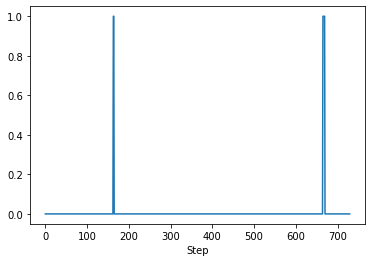

In [56]:
agent_df.xs(0, level="AgentID").Activ.astype(float).plot()

In [57]:
model_df = model.datacollector.get_model_vars_dataframe()
model_df.tail(20)


,Active Burglars,Hotspots,Total Hotspots
710,15,201,3515
711,14,201,3520
712,15,196,3523
713,17,183,3528
714,14,189,3534
715,10,191,3541
716,10,197,3548
717,8,198,3554
718,12,190,3556
719,17,186,3560


<AxesSubplot:>

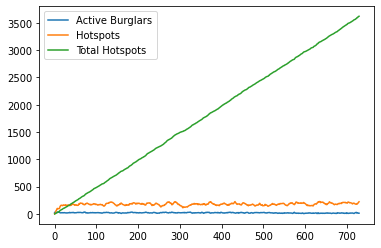

In [58]:
model_df.plot()

# Visualization

In [59]:
def agent_portrayal(agent):
    portrayal = {"Shape": "rect",
                 "Filled": "true",
                 "Layer": 1,
                 "w": 1, 
                 "h": 1}
    
    if isinstance(agent, BurglarAgent):
        portrayal["Color"] = "White"
        portrayal["r"] = 0.5
        portrayal["Shape"] = "circle"
        if agent.active == False:
            portrayal["r"] = 0

    if isinstance(agent, HouseAgent):
        portrayal["Layer"] = 0
        
    
        if agent.attractiveness_static + agent.attractiveness_dynamic > 0.5:
            portrayal["Color"] = "#ec3807"
        elif agent.attractiveness_static + agent.attractiveness_dynamic > 0.3:
            portrayal["Color"] = "#eee614"
        elif agent.attractiveness_static + agent.attractiveness_dynamic > 0.1:
            portrayal["Color"] = "#48ec07"
        elif agent.attractiveness_static + agent.attractiveness_dynamic > 0.075:
            portrayal["Color"] = "#0ff5e7"
        elif agent.attractiveness_static + agent.attractiveness_dynamic > 0.04:
            portrayal["Color"] = "#0732ec"
        else:
            portrayal["Color"] = "#da0ddc"


    return portrayal
import collections

grid = CanvasGrid(agent_portrayal, 50, 50, 500, 500)
server = ModularServer(BurglaryModel, [grid], "Burglary Model", 
{"size":50, "spacing":1, "attractiveness":1/30, 
"attractiveness_increase":0.56, "neighborhood_effects":0.2, 
"attractiveness_decay_rate":1/15, "burglary_regeneration":0.019})

In [60]:
#server.port = 8525 # The default 8521 - increase the counter as you run the visalizations
#server.launch() # Uncomment to run the visalization

# Batch run

In [61]:
params_a = {
    "size": 50,
    "spacing": 1,
    "attractiveness": 1/30,
    "attractiveness_increase": 0.56,
    "neighborhood_effects": 0.2,
    "attractiveness_decay_rate": 1/15,
    "burglary_regeneration": 0.019,
    }
results_a = batch_run(
    BurglaryModel,
    parameters=params_a,
    iterations=5,
    max_steps=730,
    number_processes=1,
    data_collection_period=-1,
    display_progress=True,
)
result_a = pd.DataFrame(results_a)

0it [00:00, ?it/s]/home/augustin/UNI/cmss/.venv/lib/python3.10/site-packages/mesa/space.py:209: UserWarning: `neighbor_iter` is deprecated in favor of `iter_neighbors` and will be removed in the subsequent version.
  warn(
5it [01:02, 12.54s/it]


In [62]:
result_a.groupby(by=["RunId", "iteration", "Step"]).mean()

,,,size,spacing,attractiveness,attractiveness_increase,neighborhood_effects,attractiveness_decay_rate,burglary_regeneration,Active Burglars,Hotspots,Total Hotspots,AgentID,Attractiveness_dynamic,Burglaries,Regeneration
RunId,iteration,Step,,,,,,,,,,,,,,
0,0,730,50.0,1.0,0.033333,0.56,0.2,0.066667,0.019,54.0,183.0,33432.0,2499.5,0.153316,13.3728,0.444790
1,1,730,50.0,1.0,0.033333,0.56,0.2,0.066667,0.019,60.0,199.0,33415.0,2499.5,0.154462,13.3660,0.446941
2,2,730,50.0,1.0,0.033333,0.56,0.2,0.066667,0.019,88.0,170.0,33381.0,2499.5,0.149214,13.3524,0.447708
3,3,730,50.0,1.0,0.033333,0.56,0.2,0.066667,0.019,87.0,179.0,33398.0,2499.5,0.145224,13.3592,0.443604
4,4,730,50.0,1.0,0.033333,0.56,0.2,0.066667,0.019,85.0,151.0,33390.0,2499.5,0.144803,13.3560,0.458295


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=974054f9-a430-4125-8e5a-f64b08b644a3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [63]:
params_c = {
    "size": 50,
    "spacing": 1,
    "attractiveness": 1/30,
    "attractiveness_increase": 0.56,
    "neighborhood_effects": 0.03,
    "attractiveness_decay_rate": 1/15,
    "burglary_regeneration": 0.019,
    }
results_c = batch_run(
    BurglaryModel,
    parameters=params_c,
    iterations=5,
    max_steps=730,
    number_processes=1,
    data_collection_period=-1,
    display_progress=True,
)
result_c = pd.DataFrame(results_c)

0it [00:00, ?it/s]/home/augustin/UNI/cmss/.venv/lib/python3.10/site-packages/mesa/space.py:209: UserWarning: `neighbor_iter` is deprecated in favor of `iter_neighbors` and will be removed in the subsequent version.
  warn(
5it [01:08, 13.73s/it]


In [64]:
result_c.groupby(by=["RunId", "iteration", "Step"]).median()

,,,size,spacing,attractiveness,attractiveness_increase,neighborhood_effects,attractiveness_decay_rate,burglary_regeneration,Active Burglars,Hotspots,Total Hotspots,AgentID,Attractiveness_dynamic,Burglaries,Regeneration
RunId,iteration,Step,,,,,,,,,,,,,,
0,0,730,50.0,1.0,0.033333,0.56,0.03,0.066667,0.019,45.0,123.0,33516.0,2499.5,0.008836,0.0,0.437
1,1,730,50.0,1.0,0.033333,0.56,0.03,0.066667,0.019,70.0,122.0,33484.0,2499.5,0.008534,0.0,0.437
2,2,730,50.0,1.0,0.033333,0.56,0.03,0.066667,0.019,59.0,116.0,33535.0,2499.5,0.007142,0.0,0.437
3,3,730,50.0,1.0,0.033333,0.56,0.03,0.066667,0.019,57.0,120.0,33537.0,2499.5,0.007519,0.0,0.418
4,4,730,50.0,1.0,0.033333,0.56,0.03,0.066667,0.019,44.0,113.0,33552.0,2499.5,0.008416,0.0,0.437


In [65]:
params_b = {
    "size": 50,
    "spacing": 1,
    "attractiveness": 1/30,
    "attractiveness_increase": 5.6,
    "neighborhood_effects": 0.2,
    "attractiveness_decay_rate": 1/15,
    "burglary_regeneration": 0.002,
    }
results_b = batch_run(
    BurglaryModel,
    parameters=params_b,
    iterations=5,
    max_steps=730,
    number_processes=1,
    data_collection_period=-1,
    display_progress=True,
)
result_b = pd.DataFrame(results_b)

0it [00:00, ?it/s]/home/augustin/UNI/cmss/.venv/lib/python3.10/site-packages/mesa/space.py:209: UserWarning: `neighbor_iter` is deprecated in favor of `iter_neighbors` and will be removed in the subsequent version.
  warn(
5it [01:05, 13.14s/it]


In [66]:
result_b.groupby(by=["RunId", "iteration", "Step"]).median()

,,,size,spacing,attractiveness,attractiveness_increase,neighborhood_effects,attractiveness_decay_rate,burglary_regeneration,Active Burglars,Hotspots,Total Hotspots,AgentID,Attractiveness_dynamic,Burglaries,Regeneration
RunId,iteration,Step,,,,,,,,,,,,,,
0,0,730,50.0,1.0,0.033333,5.6,0.2,0.066667,0.002,17.0,133.0,3616.0,2499.5,0.028046,0.0,0.496
1,1,730,50.0,1.0,0.033333,5.6,0.2,0.066667,0.002,10.0,203.0,3673.0,2499.5,0.028430,0.0,0.476
2,2,730,50.0,1.0,0.033333,5.6,0.2,0.066667,0.002,17.0,164.0,3618.0,2499.5,0.042375,0.0,0.502
3,3,730,50.0,1.0,0.033333,5.6,0.2,0.066667,0.002,18.0,152.0,3620.0,2499.5,0.026442,0.0,0.493
4,4,730,50.0,1.0,0.033333,5.6,0.2,0.066667,0.002,18.0,233.0,3638.0,2499.5,0.039668,0.0,0.490


In [67]:
params_d = {
    "size": 50,
    "spacing": 1,
    "attractiveness": 1/30,
    "attractiveness_increase": 5.6,
    "neighborhood_effects": 0.03,
    "attractiveness_decay_rate": 1/15,
    "burglary_regeneration": 0.002,
    }
results_d = batch_run(
    BurglaryModel,
    parameters=params_d,
    iterations=5,
    max_steps=730,
    number_processes=1,
    data_collection_period=-1,
    display_progress=True,
)
result_d = pd.DataFrame(results_d)

0it [00:00, ?it/s]/home/augustin/UNI/cmss/.venv/lib/python3.10/site-packages/mesa/space.py:209: UserWarning: `neighbor_iter` is deprecated in favor of `iter_neighbors` and will be removed in the subsequent version.
  warn(
5it [01:05, 13.01s/it]


In [68]:
result_d.groupby(by=["RunId", "iteration", "Step"]).median()

,,,size,spacing,attractiveness,attractiveness_increase,neighborhood_effects,attractiveness_decay_rate,burglary_regeneration,Active Burglars,Hotspots,Total Hotspots,AgentID,Attractiveness_dynamic,Burglaries,Regeneration
RunId,iteration,Step,,,,,,,,,,,,,,
0,0,730,50.0,1.0,0.033333,5.6,0.03,0.066667,0.002,10.0,100.0,3635.0,2499.5,0.002484,0.0,0.499
1,1,730,50.0,1.0,0.033333,5.6,0.03,0.066667,0.002,14.0,112.0,3637.0,2499.5,0.002957,0.0,0.490
2,2,730,50.0,1.0,0.033333,5.6,0.03,0.066667,0.002,10.0,110.0,3628.0,2499.5,0.002456,0.0,0.494
3,3,730,50.0,1.0,0.033333,5.6,0.03,0.066667,0.002,22.0,107.0,3642.0,2499.5,0.002640,0.0,0.480
4,4,730,50.0,1.0,0.033333,5.6,0.03,0.066667,0.002,8.0,137.0,3623.0,2499.5,0.002467,0.0,0.498


## Desriptive statistics

Statistics in overleaf have been based on 1 iteration per simulation and 730 steps

These are based on 5 iterations and 100 steps!!! (difference in mean, std, etc.!!)

However, doesn't make sense yet because for example in the dict, 8000 * 0 houses have been burgled but there are only 2500 houses on the grid!! - has to be divided by the number of iterations

In [69]:
steps = 100         # adjust based batch run 
iterations = 5      # adjust based batch run 

In [70]:
def df_to_burglaries_norm(df, num_burglars):
    df_ready = df[df["iteration"] == iterations-2]
    series_norm = df_ready["Burglaries"].div(num_burglars).round(4)
    df_norm = pd.DataFrame(series_norm)
    mean = series_norm.mean()
    std = series_norm.std()
    med = series_norm.median()
    return df_ready, df_norm, mean, std, med, series_norm

In [71]:
# enter index position 0 for the original dataframe and position 1 for the normalized one 


df_new = pd.DataFrame({"A": df_to_burglaries_norm(result_a, 271)[1]["Burglaries"],
                        "B": df_to_burglaries_norm(result_b, 27)[1]["Burglaries"],
                        "C": df_to_burglaries_norm(result_c, 271)[1]["Burglaries"],
                        "D": df_to_burglaries_norm(result_d, 27)[1]["Burglaries"]})

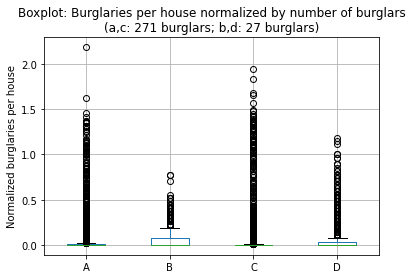

In [88]:
df_new.boxplot(column=["A", "B", "C", "D"])
plt.title("Boxplot: Burglaries per house normalized by number of burglars\n(a,c: 271 burglars; b,d: 27 burglars)")
plt.ylabel("Normalized burglaries per house")
plt.savefig("boxplot_normalized_burglaries.png")
plt.show()

In [73]:
def df_to_burglaries_dict(df):
    df_ready = df[df["iteration"] == iterations-2] 
    results = df_ready["Burglaries"].value_counts().to_dict()
    burglaries_dict = results.items()
    burglaries_dict = sorted(burglaries_dict)
    return burglaries_dict

In [74]:
# tuples: (number of instances with particular number of burglaries, number of burglaries)

print(df_to_burglaries_dict(result_a))
print(df_to_burglaries_dict(result_b))
print(df_to_burglaries_dict(result_c))
print(df_to_burglaries_dict(result_d))


[(0.0, 1565), (1.0, 285), (2.0, 103), (3.0, 68), (4.0, 30), (5.0, 50), (6.0, 26), (7.0, 23), (8.0, 13), (9.0, 10), (10.0, 14), (11.0, 19), (12.0, 12), (13.0, 11), (14.0, 5), (15.0, 6), (16.0, 7), (17.0, 9), (18.0, 4), (19.0, 8), (20.0, 5), (21.0, 3), (22.0, 4), (23.0, 6), (24.0, 2), (25.0, 1), (26.0, 4), (27.0, 2), (28.0, 1), (29.0, 3), (30.0, 3), (31.0, 2), (32.0, 3), (33.0, 4), (34.0, 1), (35.0, 5), (36.0, 5), (37.0, 4), (38.0, 1), (39.0, 4), (40.0, 5), (41.0, 2), (43.0, 1), (44.0, 1), (45.0, 2), (46.0, 1), (47.0, 1), (48.0, 1), (50.0, 2), (51.0, 1), (54.0, 1), (56.0, 1), (59.0, 2), (60.0, 1), (61.0, 1), (62.0, 1), (63.0, 2), (65.0, 2), (67.0, 1), (69.0, 2), (70.0, 2), (71.0, 2), (73.0, 1), (74.0, 3), (76.0, 3), (79.0, 1), (81.0, 1), (82.0, 1), (83.0, 1), (85.0, 1), (86.0, 1), (87.0, 1), (90.0, 2), (93.0, 1), (94.0, 2), (97.0, 1), (100.0, 1), (101.0, 2), (102.0, 1), (103.0, 1), (105.0, 1), (106.0, 1), (107.0, 2), (108.0, 1), (109.0, 1), (111.0, 2), (112.0, 2), (115.0, 1), (119.0, 1),

In [75]:
print("normalized mean, std, median A:")
print(df_to_burglaries_norm(result_a, 271)[2:5])
print("normalized mean, std, median B:")
print(df_to_burglaries_norm(result_b, 27)[2:5])
print("normalized mean, std, median C:")
print(df_to_burglaries_norm(result_c, 271)[2:5])
print("normalized mean, std, median D:")
print(df_to_burglaries_norm(result_d, 27)[2:5])

normalized mean, std, median A:
(0.0492996, 0.18619552814641033, 0.0)
normalized mean, std, median B:
(0.053623880000000006, 0.0895652695231109, 0.0)
normalized mean, std, median C:
(0.04950332, 0.20142750443967558, 0.0)
normalized mean, std, median D:
(0.05395320000000001, 0.13282454572005242, 0.0)


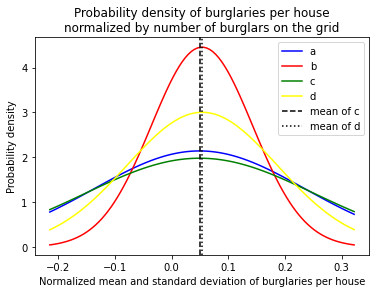

In [102]:
# mean and std are used for this plot, based on df

mu_a = df_to_burglaries_norm(result_a, 271)[2]
sigma_a = df_to_burglaries_norm(result_a, 271)[3]

mu_b = df_to_burglaries_norm(result_b, 27)[2]
sigma_b = df_to_burglaries_norm(result_b, 27)[3]

mu_c = df_to_burglaries_norm(result_c, 271)[2]
sigma_c = df_to_burglaries_norm(result_c, 271)[3]

mu_d = df_to_burglaries_norm(result_d, 27)[2]
sigma_d = df_to_burglaries_norm(result_d, 27)[3]


x = np.linspace(mu_b - 3*sigma_b, mu_b + 3*sigma_b, 100)
#x = np.linspace(-1.5, 1.5, 100)

plt.plot(x, stats.norm.pdf(x, mu_a, sigma_a), label="a", color="blue")
plt.plot(x, stats.norm.pdf(x, mu_b, sigma_b), label="b", color="red")
plt.plot(x, stats.norm.pdf(x, mu_c, sigma_c), label="c", color="green")
plt.plot(x, stats.norm.pdf(x, mu_d, sigma_d), label="d", color="yellow")

plt.axvline(mu_c, linestyle="dashed", label="mean of c", color="black")
plt.axvline(mu_d, linestyle="dotted", label="mean of d", color="black")



plt.title("Probability density of burglaries per house\nnormalized by number of burglars on the grid")
plt.legend()
plt.xlabel("Normalized mean and standard deviation of burglaries per house")
plt.ylabel("Probability density")
plt.savefig("probability_new.png")
plt.show()

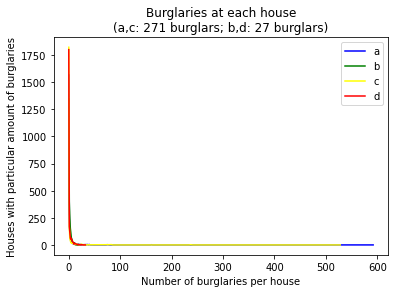

In [104]:
# dictionary is used for this plot

a_list = df_to_burglaries_dict(result_a)
b_list = df_to_burglaries_dict(result_b)
c_list = df_to_burglaries_dict(result_c)
d_list = df_to_burglaries_dict(result_d)

xa, ya = zip(*a_list)
xb,yb = zip(*b_list)
xc, yc = zip(*c_list)
xd,yd = zip(*d_list)

plt.plot(xa, ya, label = "a", color="blue")
plt.plot(xb, yb, label = "b", color="green")
plt.plot(xc, yc, label = "c", color="yellow")
plt.plot(xd, yd, label = "d", color="red")
#plt.xlim(0, 7)                                                                   # include this for scaling
plt.title("Burglaries at each house\n(a,c: 271 burglars; b,d: 27 burglars)")
plt.xlabel("Number of burglaries per house")
plt.ylabel("Houses with particular amount of burglaries")
plt.legend()
plt.savefig("buglaries_limit.png")
plt.show()

# Hotspot Analysis

In [80]:

result_d[['RunId', 'iteration','Step', 'Active Burglars','Hotspots', 'Total Hotspots']].mean()

RunId                 2.0
iteration             2.0
Step                730.0
Active Burglars      12.8
Hotspots            113.2
Total Hotspots     3633.0
dtype: float64

In [81]:
hotspots_a = result_a[['RunId', 'iteration','Step', 'Active Burglars','Hotspots', 'Total Hotspots']].copy()
hotspots_b = result_b[['RunId', 'iteration','Step', 'Active Burglars','Hotspots', 'Total Hotspots']].copy()
hotspots_c = result_c[['RunId', 'iteration','Step', 'Active Burglars','Hotspots', 'Total Hotspots']].copy()
hotspots_d = result_d[['RunId', 'iteration','Step', 'Active Burglars','Hotspots', 'Total Hotspots']].copy()


In [142]:
hotspots_a.describe()

,RunId,iteration,Step,Active Burglars,Hotspots,Total Hotspots
count,25000.000000,25000.000000,25000.0,25000.000000,25000.000000,25000.000000
mean,2.000000,2.000000,730.0,74.800000,176.400000,33403.200000
std,1.414242,1.414242,0.0,14.689065,15.793986,18.236592
min,0.000000,0.000000,730.0,54.000000,151.000000,33381.000000
25%,1.000000,1.000000,730.0,60.000000,170.000000,33390.000000
50%,2.000000,2.000000,730.0,85.000000,179.000000,33398.000000
75%,3.000000,3.000000,730.0,87.000000,183.000000,33415.000000
max,4.000000,4.000000,730.0,88.000000,199.000000,33432.000000


In [143]:
hotspots_b.describe()

,RunId,iteration,Step,Active Burglars,Hotspots,Total Hotspots
count,25000.000000,25000.000000,25000.0,25000.000000,25000.000000,25000.000000
mean,2.000000,2.000000,730.0,16.000000,177.000000,3633.000000
std,1.414242,1.414242,0.0,3.033211,36.172536,21.485308
min,0.000000,0.000000,730.0,10.000000,133.000000,3616.000000
25%,1.000000,1.000000,730.0,17.000000,152.000000,3618.000000
50%,2.000000,2.000000,730.0,17.000000,164.000000,3620.000000
75%,3.000000,3.000000,730.0,18.000000,203.000000,3638.000000
max,4.000000,4.000000,730.0,18.000000,233.000000,3673.000000


In [144]:
hotspots_c.describe()

,RunId,iteration,Step,Active Burglars,Hotspots,Total Hotspots
count,25000.000000,25000.000000,25000.0,25000.000000,25000.000000,25000.000000
mean,2.000000,2.000000,730.0,55.000000,118.800000,33524.800000
std,1.414242,1.414242,0.0,9.654208,3.763053,23.387644
min,0.000000,0.000000,730.0,44.000000,113.000000,33484.000000
25%,1.000000,1.000000,730.0,45.000000,116.000000,33516.000000
50%,2.000000,2.000000,730.0,57.000000,120.000000,33535.000000
75%,3.000000,3.000000,730.0,59.000000,122.000000,33537.000000
max,4.000000,4.000000,730.0,70.000000,123.000000,33552.000000


In [146]:
hotspots_d.describe()

,RunId,iteration,Step,Active Burglars,Hotspots,Total Hotspots
count,25000.000000,25000.000000,25000.0,25000.000000,25000.000000,25000.000000
mean,2.000000,2.000000,730.0,12.800000,113.200000,3633.000000
std,1.414242,1.414242,0.0,4.996098,12.576419,6.723229
min,0.000000,0.000000,730.0,8.000000,100.000000,3623.000000
25%,1.000000,1.000000,730.0,10.000000,107.000000,3628.000000
50%,2.000000,2.000000,730.0,10.000000,110.000000,3635.000000
75%,3.000000,3.000000,730.0,14.000000,112.000000,3637.000000
max,4.000000,4.000000,730.0,22.000000,137.000000,3642.000000


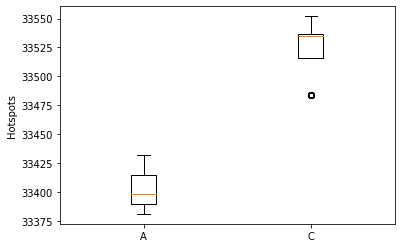

In [135]:
boxplot_df = pd.DataFrame({
    'A': hotspots_a['Total Hotspots'],
    'C': hotspots_c['Total Hotspots'],
})
plt.boxplot(boxplot_df, labels=["A", "C"])
plt.ylabel("Hotspots")
plt.savefig("hotspots_a_c.png")
plt.show()

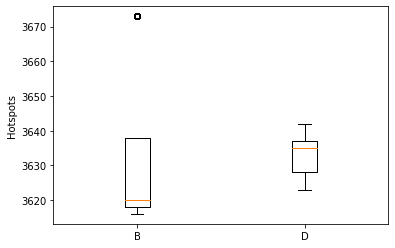

In [136]:
boxplot_df = pd.DataFrame({
    'B': hotspots_b['Total Hotspots'],
    'D': hotspots_d['Total Hotspots'],
})
plt.boxplot(boxplot_df, labels=["B", "D"])
plt.ylabel("Hotspots")
plt.savefig("hotspots_b_d.png")
plt.show()

## Models - Active Hotspots vs Active Burglars

In [137]:
steps = 730
def run_model(params, name):
    model = BurglaryModel(**params)
    while model.schedule.steps < steps:
        model.step()
    model_df = model.datacollector.get_model_vars_dataframe()
    plt.plot(model_df[['Active Burglars', 'Hotspots']], label=['Active Burglars', 'Active Hotspots'])
    plt.legend(loc=1)
    plt.savefig(str(name) + ".png")
    plt.show()

/home/augustin/UNI/cmss/.venv/lib/python3.10/site-packages/mesa/space.py:209: UserWarning: `neighbor_iter` is deprecated in favor of `iter_neighbors` and will be removed in the subsequent version.
  warn(


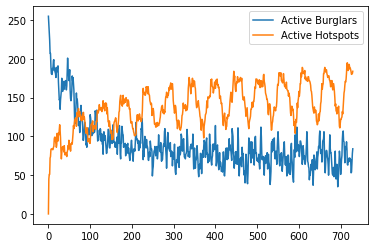

/home/augustin/UNI/cmss/.venv/lib/python3.10/site-packages/mesa/space.py:209: UserWarning: `neighbor_iter` is deprecated in favor of `iter_neighbors` and will be removed in the subsequent version.
  warn(


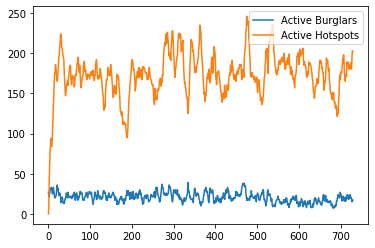

/home/augustin/UNI/cmss/.venv/lib/python3.10/site-packages/mesa/space.py:209: UserWarning: `neighbor_iter` is deprecated in favor of `iter_neighbors` and will be removed in the subsequent version.
  warn(


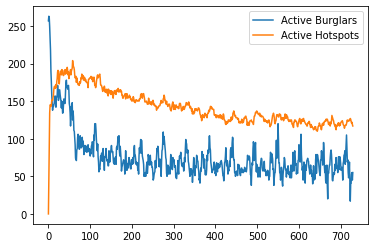

/home/augustin/UNI/cmss/.venv/lib/python3.10/site-packages/mesa/space.py:209: UserWarning: `neighbor_iter` is deprecated in favor of `iter_neighbors` and will be removed in the subsequent version.
  warn(


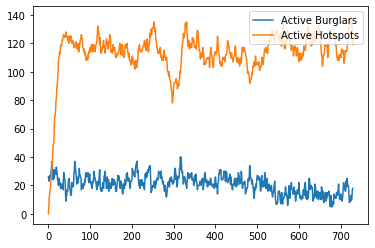

In [138]:
params_all = [params_a, params_b, params_c, params_d]
for i, params in enumerate(params_all):
    run_model(params, i)